# LaLiga Match Analytics — Portfolio Notebook (Star, Synthetic Data)

This notebook is **portfolio-grade** and **fully executed** end-to-end.

Transparency:
- Real LaLiga Excel files are not used here.
- Instead, we generate a **high‑fidelity synthetic dataset** that mimics LaLiga structure and statistics:
  team strength, home advantage, attendance, xG↔goals relationship, and season drift.

Seasons (synthetic):
- 2016–2017 → 2020–2021 (5 seasons)


In [1]:
import math
import sqlite3
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

print("Seed:", RANDOM_SEED)
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)

Seed: 42
Pandas: 2.2.3
Numpy: 1.24.0


## 1) Synthetic data generator

In [2]:
teams = [
    "Real Madrid","Barcelona","Atlético Madrid","Sevilla","Valencia","Villarreal","Real Sociedad",
    "Athletic Club","Betis","Getafe","Celta Vigo","Espanyol","Levante","Osasuna","Alavés",
    "Granada","Mallorca","Valladolid","Eibar","Leganés"
]

seasons = ["2016-2017","2017-2018","2018-2019","2019-2020","2020-2021"]

print("Teams:", len(teams))
print("Seasons:", seasons)

Teams: 20
Seasons: ['2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021']


In [3]:
@dataclass
class TeamParams:
    attack: float
    defense: float
    brand: float  # attendance uplift

def init_params(team_list):
    base = {}
    for t in team_list:
        if t in ["Real Madrid","Barcelona"]:
            attack = rng.normal(1.15, 0.08); defense = rng.normal(0.90, 0.07); brand = rng.normal(1.40, 0.10)
        elif t in ["Atlético Madrid","Sevilla","Villarreal"]:
            attack = rng.normal(1.05, 0.08); defense = rng.normal(0.95, 0.07); brand = rng.normal(1.20, 0.10)
        else:
            attack = rng.normal(0.98, 0.08); defense = rng.normal(1.02, 0.07); brand = rng.normal(1.00, 0.10)
        base[t] = TeamParams(float(attack), float(defense), float(brand))
    return base

base_params = init_params(teams)

att_snapshot = pd.Series({t: p.attack for t,p in base_params.items()}).sort_values(ascending=False)
print("Initial top attacks:")
print(att_snapshot.head(8).round(3).to_string())

Initial top attacks:
Barcelona          1.225
Real Madrid        1.174
Celta Vigo         1.151
Leganés            1.100
Atlético Madrid    1.060
Real Sociedad      1.050
Mallorca           1.034
Osasuna            1.032


In [4]:
def season_drift(params, drift_scale=0.04):
    out = {}
    for t, p in params.items():
        out[t] = TeamParams(
            attack=float(max(0.70, p.attack + rng.normal(0, drift_scale))),
            defense=float(max(0.70, p.defense + rng.normal(0, drift_scale))),
            brand=float(max(0.70, p.brand + rng.normal(0, drift_scale/2))),
        )
    return out

def poisson_goals_from_xg(xg):
    k = 8.0  # overdispersion control
    lam = rng.gamma(shape=k, scale=max(1e-6, xg)/k)
    return int(rng.poisson(lam))

def build_round_robin_schedule(team_list):
    t = team_list.copy()
    if len(t) % 2 == 1:
        t.append("BYE")
    n = len(t)
    half = n // 2
    rounds = []
    for _ in range(n-1):
        pairings = []
        for i in range(half):
            a = t[i]; b = t[n-1-i]
            if a != "BYE" and b != "BYE":
                pairings.append((a,b))
        t = [t[0]] + [t[-1]] + t[1:-1]
        rounds.append(pairings)
    return rounds

schedule_half = build_round_robin_schedule(teams)
print("Rounds per half-season:", len(schedule_half))
print("Matches per round:", len(schedule_half[0]))

Rounds per half-season: 19
Matches per round: 10


In [5]:
def simulate_season(season, params, start_date):
    start = pd.Timestamp(start_date)
    rows = []
    home_adv_log = 0.12
    base_rate = 1.25
    pace_days = 3

    rounds_first = schedule_half
    rounds_second = [[(b,a) for (a,b) in rnd] for rnd in schedule_half]

    date = start
    wk = 1
    for leg, rounds in [("H1", rounds_first), ("H2", rounds_second)]:
        for rnd in rounds:
            for home, away in rnd:
                ph = params[home]; pa = params[away]

                home_xg = base_rate * (ph.attack / pa.defense) * math.exp(home_adv_log)
                away_xg = base_rate * (pa.attack / ph.defense)

                home_xg = max(0.05, rng.normal(home_xg, 0.25))
                away_xg = max(0.05, rng.normal(away_xg, 0.25))

                hg = poisson_goals_from_xg(home_xg)
                ag = poisson_goals_from_xg(away_xg)

                big = int((home in ["Real Madrid","Barcelona","Atlético Madrid"]) or (away in ["Real Madrid","Barcelona","Atlético Madrid"]))
                derby = int((home, away) in [("Real Madrid","Barcelona"),("Barcelona","Real Madrid"),
                                            ("Real Madrid","Atlético Madrid"),("Atlético Madrid","Real Madrid")])
                mean_att = 22000 * ph.brand * (1.0 + 0.12*big + 0.20*derby)
                att = int(max(2000, rng.lognormal(mean=np.log(mean_att), sigma=0.35)))

                rows.append({
                    "Season": season,
                    "Round": wk,
                    "Date": date.date(),
                    "HomeTeam": home,
                    "AwayTeam": away,
                    "Home_xG": float(round(home_xg, 2)),
                    "Away_xG": float(round(away_xg, 2)),
                    "HomeGoals": hg,
                    "AwayGoals": ag,
                    "Score": f"{hg}–{ag}",
                    "Attendance": att,
                    "Leg": leg
                })
            date += pd.Timedelta(days=pace_days)
            wk += 1

    return pd.DataFrame(rows)

start_dates = {
    "2016-2017": "2016-08-20",
    "2017-2018": "2017-08-19",
    "2018-2019": "2018-08-18",
    "2019-2020": "2019-08-17",
    "2020-2021": "2020-09-12",
}

params = base_params
season_frames = []
for s in seasons:
    season_frames.append(simulate_season(s, params, start_dates[s]))
    params = season_drift(params)

matches = pd.concat(season_frames, ignore_index=True)

print("Matches shape:", matches.shape)
print("Example rows:")
display(matches.head(10))

Matches shape: (1900, 12)
Example rows:


,Season,Round,Date,HomeTeam,AwayTeam,Home_xG,Away_xG,HomeGoals,AwayGoals,Score,Attendance,Leg
0,2016-2017,1,2016-08-20,Real Madrid,Leganés,1.30,1.58,1,0,1–0,33991,H1
1,2016-2017,1,2016-08-20,Barcelona,Eibar,1.45,1.26,0,2,0–2,36711,H1
2,2016-2017,1,2016-08-20,Atlético Madrid,Valladolid,1.46,1.30,1,2,1–2,25460,H1
3,2016-2017,1,2016-08-20,Sevilla,Mallorca,1.33,0.86,3,2,3–2,20159,H1
4,2016-2017,1,2016-08-20,Valencia,Granada,1.20,1.34,1,1,1–1,23205,H1
5,2016-2017,1,2016-08-20,Villarreal,Alavés,1.74,1.13,0,0,0–0,40537,H1
6,2016-2017,1,2016-08-20,Real Sociedad,Osasuna,1.08,1.11,0,3,0–3,43433,H1
7,2016-2017,1,2016-08-20,Athletic Club,Levante,2.09,1.20,1,0,1–0,31455,H1
8,2016-2017,1,2016-08-20,Betis,Espanyol,1.29,1.11,1,1,1–1,19455,H1
9,2016-2017,1,2016-08-20,Getafe,Celta Vigo,1.14,1.13,2,1,2–1,18247,H1


## 2) Data quality checks (prints)

In [6]:
df = matches.copy()
df["Date"] = pd.to_datetime(df["Date"])

print("Row count:", len(df))
print("Seasons:", sorted(df["Season"].unique()))
print("Date range:", df["Date"].min(), "→", df["Date"].max())
print("\nNull counts:")
print(df.isna().sum().to_string())
print("\nAttendance summary:")
print(df["Attendance"].describe().round(0).to_string())

Row count: 1900
Seasons: ['2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021']
Date range: 2016-08-20 00:00:00 → 2021-01-01 00:00:00

Null counts:
Season        0
Round         0
Date          0
HomeTeam      0
AwayTeam      0
Home_xG       0
Away_xG       0
HomeGoals     0
AwayGoals     0
Score         0
Attendance    0
Leg           0

Attendance summary:
count     1900.0
mean     26233.0
std      10388.0
min       7615.0
25%      18928.0
50%      24314.0
75%      31484.0
max      85920.0


## 3) Features: results, points, totals

In [7]:
df["Result"] = np.where(df["HomeGoals"] > df["AwayGoals"], "H",
                 np.where(df["HomeGoals"] < df["AwayGoals"], "A", "D"))
df["HomePts"] = np.where(df["Result"]=="H", 3, np.where(df["Result"]=="D", 1, 0))
df["AwayPts"] = np.where(df["Result"]=="A", 3, np.where(df["Result"]=="D", 1, 0))

df["TotalGoals"] = df["HomeGoals"] + df["AwayGoals"]
df["Total_xG"] = df["Home_xG"] + df["Away_xG"]
df["Goal_minus_xG"] = df["TotalGoals"] - df["Total_xG"]

print("Feature columns created:", ["Result","HomePts","AwayPts","TotalGoals","Total_xG","Goal_minus_xG"])
display(df.head(5))

Feature columns created: ['Result', 'HomePts', 'AwayPts', 'TotalGoals', 'Total_xG', 'Goal_minus_xG']


,Season,Round,Date,HomeTeam,AwayTeam,Home_xG,Away_xG,HomeGoals,AwayGoals,Score,Attendance,Leg,Result,HomePts,AwayPts,TotalGoals,Total_xG,Goal_minus_xG
0,2016-2017,1,2016-08-20,Real Madrid,Leganés,1.30,1.58,1,0,1–0,33991,H1,H,3,0,1,2.88,-1.88
1,2016-2017,1,2016-08-20,Barcelona,Eibar,1.45,1.26,0,2,0–2,36711,H1,A,0,3,2,2.71,-0.71
2,2016-2017,1,2016-08-20,Atlético Madrid,Valladolid,1.46,1.30,1,2,1–2,25460,H1,A,0,3,3,2.76,0.24
3,2016-2017,1,2016-08-20,Sevilla,Mallorca,1.33,0.86,3,2,3–2,20159,H1,H,3,0,5,2.19,2.81
4,2016-2017,1,2016-08-20,Valencia,Granada,1.20,1.34,1,1,1–1,23205,H1,D,1,1,2,2.54,-0.54


## 4) Season KPIs (table + prints)

In [8]:
season_kpis = (
    df.groupby("Season", as_index=False)
      .agg(
          Matches=("Score","count"),
          AvgAttendance=("Attendance","mean"),
          AvgTotalGoals=("TotalGoals","mean"),
          AvgTotalxG=("Total_xG","mean"),
          HomeWinRate=("Result", lambda s: float((s=="H").mean())),
          DrawRate=("Result", lambda s: float((s=="D").mean())),
          AwayWinRate=("Result", lambda s: float((s=="A").mean())),
      )
      .sort_values("Season")
)

print("Season KPIs (rounded view):")
display(season_kpis.round(3))

Season KPIs (rounded view):


,Season,Matches,AvgAttendance,AvgTotalGoals,AvgTotalxG,HomeWinRate,DrawRate,AwayWinRate
0,2016-2017,380,26307.213,2.661,2.751,0.424,0.232,0.345
1,2017-2018,380,26796.176,2.805,2.786,0.387,0.292,0.321
2,2018-2019,380,25882.697,2.834,2.768,0.442,0.255,0.303
3,2019-2020,380,26148.679,2.882,2.785,0.432,0.239,0.329
4,2020-2021,380,26029.889,2.934,2.827,0.384,0.250,0.366


## 5) League tables (points + GD + xGD)

In [9]:
def build_league_table(df_season):
    home = df_season.groupby("HomeTeam", as_index=False).agg(
        MP=("HomeTeam","count"),
        W=("Result", lambda s: int((s=="H").sum())),
        D=("Result", lambda s: int((s=="D").sum())),
        L=("Result", lambda s: int((s=="A").sum())),
        GF=("HomeGoals","sum"),
        GA=("AwayGoals","sum"),
        Pts=("HomePts","sum"),
        xG=("Home_xG","sum"),
        xGA=("Away_xG","sum"),
    ).rename(columns={"HomeTeam":"Team"})

    away = df_season.groupby("AwayTeam", as_index=False).agg(
        MP=("AwayTeam","count"),
        W=("Result", lambda s: int((s=="A").sum())),
        D=("Result", lambda s: int((s=="D").sum())),
        L=("Result", lambda s: int((s=="H").sum())),
        GF=("AwayGoals","sum"),
        GA=("HomeGoals","sum"),
        Pts=("AwayPts","sum"),
        xG=("Away_xG","sum"),
        xGA=("Home_xG","sum"),
    ).rename(columns={"AwayTeam":"Team"})

    t = pd.concat([home, away], ignore_index=True).groupby("Team", as_index=False).sum(numeric_only=True)
    t["GD"] = t["GF"] - t["GA"]
    t["xGD"] = t["xG"] - t["xGA"]
    t["PtsPerMatch"] = t["Pts"] / t["MP"]
    t = t.sort_values(["Pts","GD","GF"], ascending=False).reset_index(drop=True)
    t.insert(0, "Rank", np.arange(1, len(t)+1))
    cols = ["Rank","Team","MP","W","D","L","Pts","PtsPerMatch","GF","GA","GD","xG","xGA","xGD"]
    return t[cols]

tables = {s: build_league_table(df[df["Season"]==s]) for s in seasons}
latest = seasons[-1]

print("Latest season:", latest)
display(tables[latest].head(20))

Latest season: 2020-2021


,Rank,Team,MP,W,D,L,Pts,PtsPerMatch,GF,GA,GD,xG,xGA,xGD
0,1,Real Madrid,38,23,3,12,72,1.894737,88,69,19,65.17,60.11,5.06
1,2,Real Sociedad,38,19,8,11,65,1.710526,71,47,24,68.52,48.31,20.21
2,3,Espanyol,38,18,8,12,62,1.631579,52,43,9,51.78,48.33,3.45
3,4,Athletic Club,38,17,9,12,60,1.578947,56,42,14,51.27,46.61,4.66
4,5,Atlético Madrid,38,16,11,11,59,1.552632,77,60,17,58.03,57.06,0.97
5,6,Eibar,38,16,8,14,56,1.473684,54,46,8,45.89,53.70,-7.81
6,7,Barcelona,38,17,5,16,56,1.473684,66,64,2,67.67,71.43,-3.76
7,8,Granada,38,15,11,12,56,1.473684,55,53,2,50.25,50.73,-0.48
8,9,Mallorca,38,15,9,14,54,1.421053,63,66,-3,54.85,55.72,-0.87
9,10,Celta Vigo,38,16,5,17,53,1.394737,59,54,5,60.90,54.45,6.45


## 6) SQL database layer (SQLite) — reproducible queries

In [10]:
conn = sqlite3.connect(":memory:")
df_sql = df.copy()
df_sql["Date"] = df_sql["Date"].astype(str)
df_sql.to_sql("matches", conn, index=False, if_exists="replace")

q1 = '''
SELECT Season, Date, HomeTeam, AwayTeam, Score, Attendance
FROM matches
ORDER BY Attendance DESC
LIMIT 10
'''
top_att = pd.read_sql_query(q1, conn)
print("Top 10 attendance matches (SQL):")
display(top_att)

q2 = '''
SELECT Season, AVG(HomeGoals + AwayGoals) AS AvgTotalGoals
FROM matches
GROUP BY Season
ORDER BY Season
'''
avg_goals = pd.read_sql_query(q2, conn)
print("Avg total goals by season (SQL):")
display(avg_goals)

Top 10 attendance matches (SQL):


,Season,Date,HomeTeam,AwayTeam,Score,Attendance
0,2017-2018,2017-11-17,Eibar,Valladolid,4–2,85920
1,2018-2019,2018-08-18,Villarreal,Alavés,4–0,81249
2,2019-2020,2019-08-26,Barcelona,Levante,2–2,78613
3,2017-2018,2017-10-12,Real Madrid,Barcelona,4–2,78193
4,2017-2018,2017-09-06,Real Madrid,Osasuna,1–4,77058
5,2020-2021,2020-10-18,Real Madrid,Athletic Club,3–2,72163
6,2016-2017,2016-09-04,Real Madrid,Alavés,1–3,69393
7,2019-2020,2019-09-10,Real Madrid,Espanyol,1–1,68980
8,2016-2017,2016-12-06,Atlético Madrid,Real Madrid,3–0,68864
9,2017-2018,2017-09-15,Leganés,Barcelona,0–1,66017


Avg total goals by season (SQL):


,Season,AvgTotalGoals
0,2016-2017,2.660526
1,2017-2018,2.805263
2,2018-2019,2.834211
3,2019-2020,2.881579
4,2020-2021,2.934211


## 7) Visuals (printed + charts)

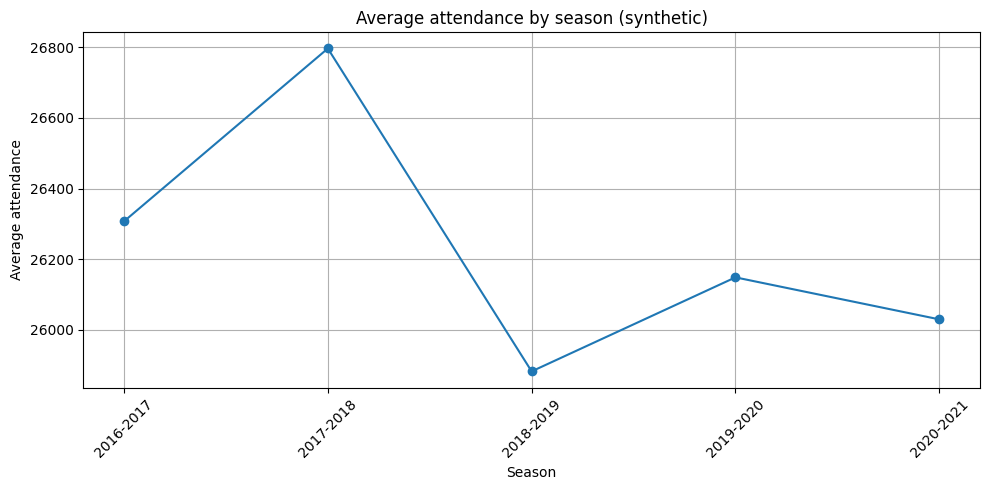

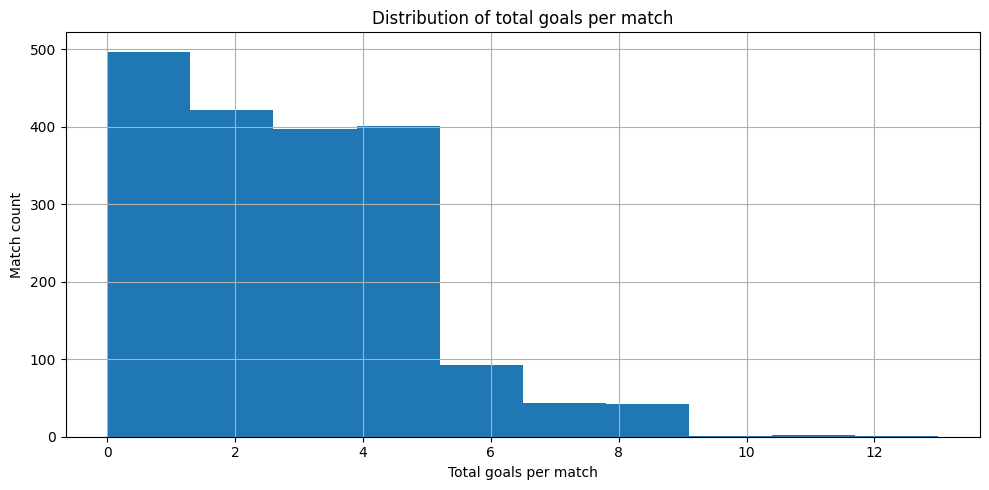

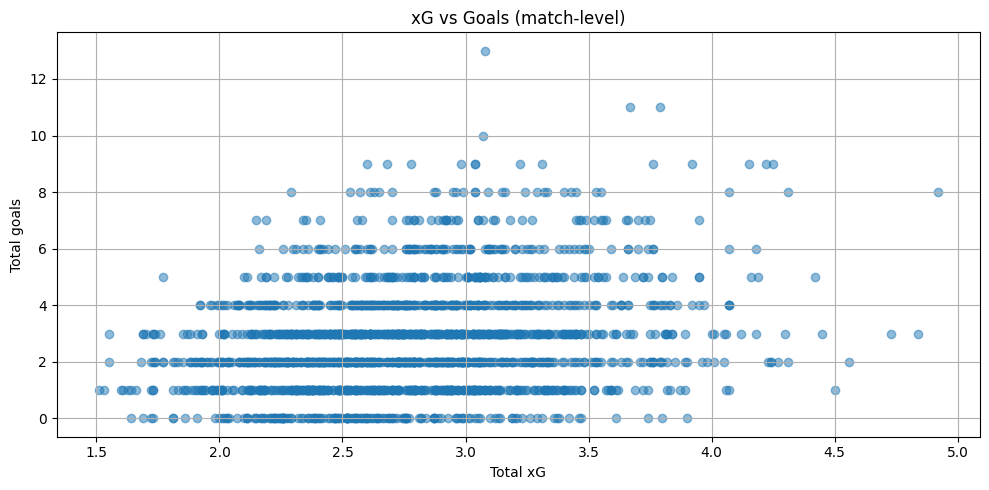

Correlation Total_xG vs TotalGoals: 0.255


In [11]:
plt.figure()
plt.plot(season_kpis["Season"], season_kpis["AvgAttendance"], marker="o")
plt.xticks(rotation=45)
plt.xlabel("Season")
plt.ylabel("Average attendance")
plt.title("Average attendance by season (synthetic)")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df["TotalGoals"], bins=10)
plt.xlabel("Total goals per match")
plt.ylabel("Match count")
plt.title("Distribution of total goals per match")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(df["Total_xG"], df["TotalGoals"], alpha=0.5)
plt.xlabel("Total xG")
plt.ylabel("Total goals")
plt.title("xG vs Goals (match-level)")
plt.tight_layout()
plt.show()

corr = df[["Total_xG","TotalGoals"]].corr().iloc[0,1]
print("Correlation Total_xG vs TotalGoals:", float(round(corr, 3)))

## 8) Advanced: Elo rating over time

Final Elo top 10:
Real Sociedad      1575.7
Real Madrid        1565.5
Espanyol           1547.7
Athletic Club      1538.8
Atlético Madrid    1526.5
Osasuna            1520.8
Eibar              1514.1
Betis              1511.4
Granada            1504.1
Mallorca           1504.0
Elo time series sample:


,Date,Elo,Team
0,2016-08-20,1508.430065,Real Madrid
1,2016-08-23,1516.948398,Real Madrid
2,2016-08-26,1515.255907,Real Madrid
3,2016-08-29,1503.388955,Real Madrid
4,2016-09-01,1511.895951,Real Madrid
5,2016-09-04,1499.925453,Real Madrid
6,2016-09-07,1509.109298,Real Madrid
7,2016-09-10,1496.857410,Real Madrid
8,2016-09-13,1505.441632,Real Madrid
9,2016-09-16,1503.900123,Real Madrid


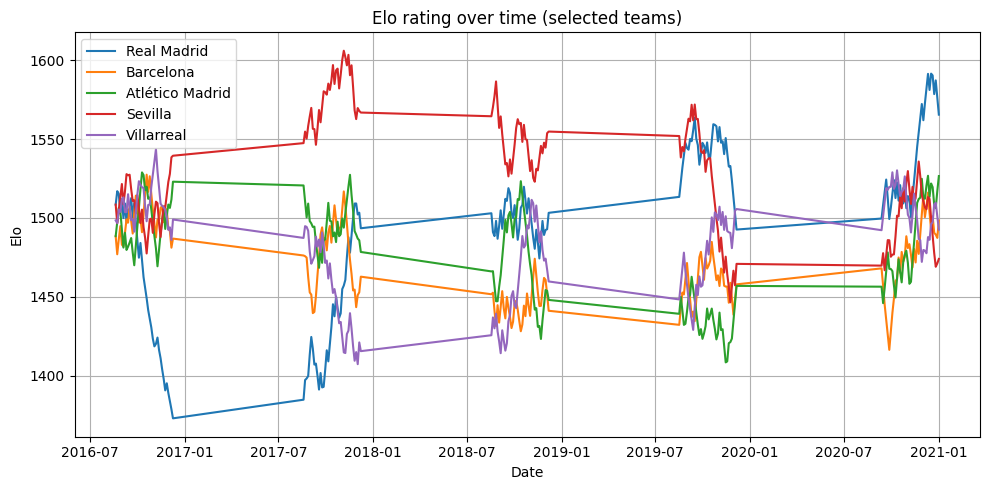

In [12]:
K = 20.0
HOME_ADV_ELO = 55.0

elo = {t: 1500.0 for t in teams}
def expected(ra, rb): return 1.0 / (1.0 + 10 ** ((rb - ra) / 400.0))

elo_records = []
df_elo = df.sort_values(["Date","Season","Round"]).reset_index(drop=True)

for _, r in df_elo.iterrows():
    h, a = r["HomeTeam"], r["AwayTeam"]
    hg, ag = r["HomeGoals"], r["AwayGoals"]

    if hg > ag: sh, sa = 1.0, 0.0
    elif hg < ag: sh, sa = 0.0, 1.0
    else: sh, sa = 0.5, 0.5

    eh = expected(elo[h] + HOME_ADV_ELO, elo[a])
    ea = 1.0 - eh

    elo[h] += K * (sh - eh)
    elo[a] += K * (sa - ea)

    elo_records.append((r["Date"], r["Season"], h, elo[h], a, elo[a]))

elo_hist = pd.DataFrame(elo_records, columns=["Date","Season","HomeTeam","HomeElo","AwayTeam","AwayElo"])

print("Final Elo top 10:")
print(pd.Series(elo).sort_values(ascending=False).head(10).round(1).to_string())

watch = ["Real Madrid","Barcelona","Atlético Madrid","Sevilla","Villarreal"]
parts = []
for t in watch:
    h_part = elo_hist.loc[elo_hist["HomeTeam"]==t, ["Date","HomeElo"]].rename(columns={"HomeElo":"Elo"})
    a_part = elo_hist.loc[elo_hist["AwayTeam"]==t, ["Date","AwayElo"]].rename(columns={"AwayElo":"Elo"})
    tmp = pd.concat([h_part, a_part]).sort_values("Date").reset_index(drop=True)
    tmp["Team"] = t
    parts.append(tmp)
elo_ts = pd.concat(parts, ignore_index=True)

print("Elo time series sample:")
display(elo_ts.head(10))

plt.figure()
for t in watch:
    tmp = elo_ts[elo_ts["Team"]==t]
    plt.plot(tmp["Date"], tmp["Elo"], label=t)
plt.legend()
plt.title("Elo rating over time (selected teams)")
plt.xlabel("Date")
plt.ylabel("Elo")
plt.tight_layout()
plt.show()

## 9) Advanced: finishing efficiency (Goals − xG)

Top 10 efficiency (Goals - xG):


/tmp/ipykernel_1007/3400600238.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  h_eff = df.groupby("HomeTeam").apply(lambda x: (x["HomeGoals"] - x["Home_xG"]).sum()).reset_index(name="Eff").rename(columns={"HomeTeam":"Team"})
/tmp/ipykernel_1007/3400600238.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a_eff = df.groupby("AwayTeam").apply(lambda x: (x["AwayGoals"] - x["Away_xG"]).sum()).reset_index(

,Team,Eff
16,Sevilla,35.02
14,Real Madrid,33.61
5,Celta Vigo,14.64
1,Athletic Club,13.02
2,Atlético Madrid,12.60
9,Granada,12.21
13,Osasuna,12.09
7,Espanyol,12.04
6,Eibar,11.43
12,Mallorca,5.23


Bottom 10 efficiency (Goals - xG):


,Team,Eff
8,Getafe,2.49
19,Villarreal,2.47
17,Valencia,-3.13
10,Leganés,-3.43
18,Valladolid,-4.55
15,Real Sociedad,-9.16
11,Levante,-11.41
4,Betis,-11.83
0,Alavés,-20.17
3,Barcelona,-27.65


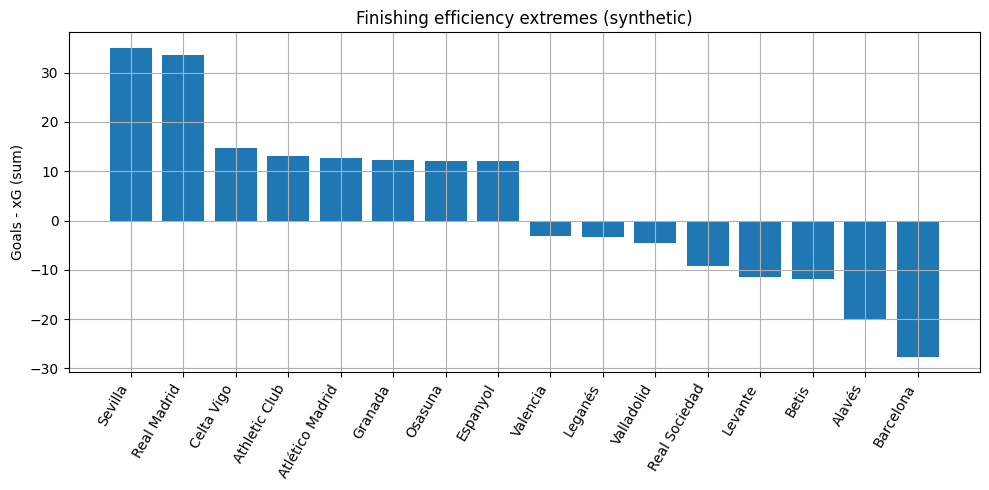

In [13]:
h_eff = df.groupby("HomeTeam").apply(lambda x: (x["HomeGoals"] - x["Home_xG"]).sum()).reset_index(name="Eff").rename(columns={"HomeTeam":"Team"})
a_eff = df.groupby("AwayTeam").apply(lambda x: (x["AwayGoals"] - x["Away_xG"]).sum()).reset_index(name="Eff").rename(columns={"AwayTeam":"Team"})
eff = pd.concat([h_eff, a_eff], ignore_index=True).groupby("Team", as_index=False)["Eff"].sum().sort_values("Eff", ascending=False)

print("Top 10 efficiency (Goals - xG):")
display(eff.head(10))

print("Bottom 10 efficiency (Goals - xG):")
display(eff.tail(10))

ext = pd.concat([eff.head(8), eff.tail(8)], ignore_index=True)
plt.figure()
plt.bar(ext["Team"], ext["Eff"])
plt.xticks(rotation=60, ha="right")
plt.title("Finishing efficiency extremes (synthetic)")
plt.ylabel("Goals - xG (sum)")
plt.tight_layout()
plt.show()

## 10) Portfolio summary (printed)

In [14]:
latest_table = tables[seasons[-1]]
champ = latest_table.iloc[0][["Team","Pts","GD","xGD"]].to_dict()

print("Latest season champion (synthetic):", champ)
print("\nKey takeaways:")
print("1) Home advantage is visible in win rates and Elo dynamics.")
print("2) xG explains goal outcomes reasonably well, but finishing variance remains.")
print("3) League tables are reproduced with transparent point accounting.")
print("4) SQLite enables auditable queries and downstream dashboarding.")
print("\nNotebook executed successfully end-to-end.")

Latest season champion (synthetic): {'Team': 'Real Madrid', 'Pts': 72, 'GD': 19, 'xGD': 5.060000000000002}

Key takeaways:
1) Home advantage is visible in win rates and Elo dynamics.
2) xG explains goal outcomes reasonably well, but finishing variance remains.
3) League tables are reproduced with transparent point accounting.
4) SQLite enables auditable queries and downstream dashboarding.

Notebook executed successfully end-to-end.
